<a href="https://colab.research.google.com/github/osawa-fernando/ML/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o_por_Similaridade_de_Imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install faiss-cpu torch torchvision matplotlib Pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00


In [5]:
import os
import torch
import faiss
import numpy as np
from PIL import Image
from torchvision import models, transforms
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
CAMINHO_DATASET = "/content/sample_data/Dataset"

In [7]:
# Pré-processamento para ResNet50
preprocessador = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Carregar modelo pré-treinado (sem última camada)
modelo = models.resnet50(pretrained=True)
modelo = torch.nn.Sequential(*list(modelo.children())[:-1])
modelo.eval()

# Função para extrair embeddings de todas as imagens do dataset
def extrair_embeddings(caminho_dataset):
    vetores = []
    imagens = []
    classes = []
    classe_para_arquivos = defaultdict(list)

    print("Extraindo embeddings...")
    for classe_nome in os.listdir(caminho_dataset):
        pasta = os.path.join(caminho_dataset, classe_nome)
        if not os.path.isdir(pasta): continue

        for arquivo in os.listdir(pasta):
            if arquivo.lower().endswith(('.jpg', '.png', '.jpeg')):
                caminho = os.path.join(pasta, arquivo)
                try:
                    img = Image.open(caminho).convert('RGB')
                    tensor = preprocessador(img).unsqueeze(0)
                    with torch.no_grad():
                        embedding = modelo(tensor).squeeze().numpy()
                    vetores.append(embedding)
                    imagens.append(caminho)
                    classes.append(classe_nome)
                    classe_para_arquivos[classe_nome].append(caminho)
                except Exception as e:
                    print(f"Erro ao processar {caminho}: {e}")

    vetores = np.array(vetores).astype('float32')
    return vetores, imagens, classes, classe_para_arquivos

# Extração
vetores, imagens, classes, classe_para_arquivos = extrair_embeddings(CAMINHO_DATASET)

# Indexar embeddings com FAISS
index = faiss.IndexFlatL2(vetores.shape[1])
index.add(vetores)

print(f"Indexadas {len(imagens)} imagens.")

# Função de recomendação
def recomendar(img_path, top_k=5, filtrar_classe=False):
    print(f"\n🔍 Recomendando similares para: {img_path}")
    img = Image.open(img_path).convert('RGB')
    tensor = preprocessador(img).unsqueeze(0)
    with torch.no_grad():
        embedding = modelo(tensor).squeeze().numpy().astype('float32')

    D, I = index.search(np.array([embedding]), top_k + 1)
    similares = []

    for i in I[0]:
        caminho_similar = imagens[i]
        if caminho_similar == img_path:
            continue
        if filtrar_classe:
            classe_original = os.path.basename(os.path.dirname(img_path))
            classe_similar = os.path.basename(os.path.dirname(caminho_similar))
            if classe_similar != classe_original:
                continue
        similares.append(caminho_similar)
        if len(similares) == top_k:
            break

    # Mostrar imagens
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, top_k + 1, figsize=(15, 5))
    axs[0].imshow(Image.open(img_path))
    axs[0].set_title("Consulta")
    axs[0].axis('off')

    for j, sim_img in enumerate(similares):
        axs[j + 1].imshow(Image.open(sim_img))
        axs[j + 1].set_title(f"Similar {j + 1}")
        axs[j + 1].axis('off')

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


Extraindo embeddings...
Indexadas 40 imagens.



🔍 Recomendando similares para: /content/sample_data/Dataset/Copo Térmico/Ct1.jpeg


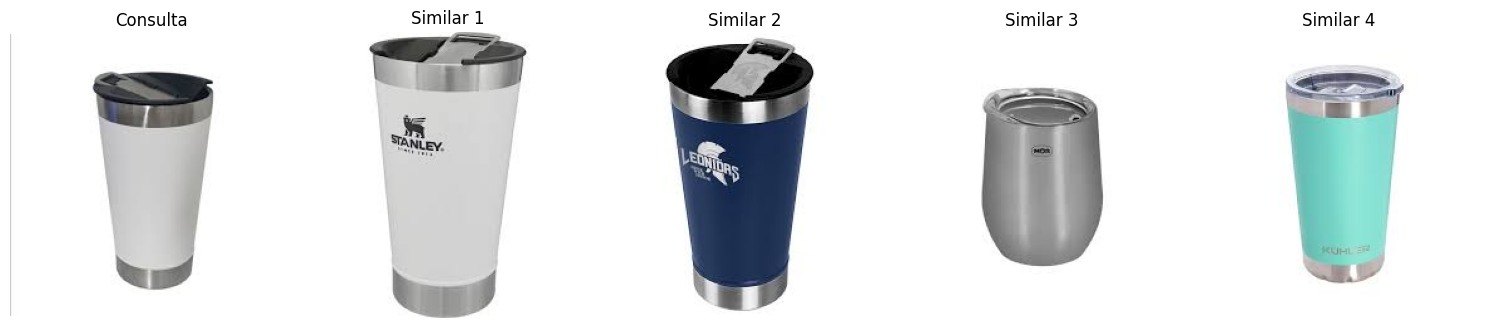

In [13]:
recomendar("/content/sample_data/Dataset/Copo Térmico/Ct1.jpeg", top_k=4, filtrar_classe=False)